# Baryonic halo model 

In this example, we illustrate how to build a baryonic halo model in CCL. We follow mostly the equations in Fedeli (2014), arXiv:1401.2997, with some small modifications.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
from scipy.special import erf
from scipy import integrate
from scipy import interpolate
from functools import partial
print(ccl.__version__)
from classes.baryon_halo_model import BaryonHaloModel

3.0.2


## Preliminaries

Generate a cosmology and a vector with wavenumbers. We will work only at $z=0$ for this example.

In [2]:
%%time
cosmo = ccl.CosmologyVanillaLCDM()  # cosmology object
k_arr = np.logspace(-3, 2, 25)  # wavenumber
a = 1.  # scale factor a z=0
bhm = BaryonHaloModel(cosmo, k_arr, a)
prefactor_dict = bhm.prefactor_dict()

All profiles (dark_matter, gas, stars) have been interpolated and stored.
CPU times: user 25 s, sys: 2.59 s, total: 27.6 s
Wall time: 5.05 s


In [3]:
%%time
# Takes 1 h 25 min to compute all of them
component = 'stars'
#pk_stars = bhm.power_spectra_dict(k_arr, component)
#pk_stars

#Let us load niko data
# Since I already calculated the power spectra, I will load them.
bhm_pk_dict = np.load("data/baryons_halo_model_pk.npy", allow_pickle=True).item()

# I will also load the terms that make up the power spectra.
terms_dict = np.load("data/baryons_halo_model_terms.npy", allow_pickle=True).item()

# You can check the available keys in the dictionaries
# bhm_pk_dict.keys(), terms_dict.keys()

CPU times: user 12 ms, sys: 3.87 ms, total: 15.8 ms
Wall time: 2.64 ms


Let us also initialize a series of halo model quantities. We will need:

- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo density profiles (for the dark matter part of the model).

In [4]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef(200, 'matter')
# The Tinker 2008 mass function
hmf_200m = ccl.halos.MassFuncTinker08(mass_def=hmd_200m, mass_def_strict=False)
# The Tinker 2010 halo bias
hbf = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m, mass_def_strict=False)
# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)
# The NFW profile to characterize the matter density around halos
pM = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM)
hmc = ccl.halos.HMCalculator(mass_function=hmf_200m, halo_bias=hbf,mass_def=hmd_200m)

The baryonic halo model consists of three ingredients: gas, stars and dark matter. The contribution of each ingredient is weighted by their energy density at $z=0$, which are given by

In [5]:
# Define some useful densities
rho_star = 7E8*cosmo['h']**2
rho_m = cosmo['Omega_m']*ccl.physical_constants.RHO_CRITICAL*cosmo['h']**2
rho_DM = cosmo['Omega_c']*ccl.physical_constants.RHO_CRITICAL*cosmo['h']**2
rho_g = rho_m - rho_star - rho_DM

We are now going to define some useful constants that we will need later.

In [6]:
#For the stellar mass fraction within halos
m_0s = 5E12/cosmo['h']
sigmas = 1.2

#For the stellar profile
x_deltas = 1/0.03

#For the gas mass fraction within halos
m_0g = 1E12/cosmo['h']
sigmag = 3

#For the gas profile
beta = 2.9

#Parameters that inform the power spectrum of the gas,
#specifically the extended component.
Fg = 0.05 #this is an example, it should be <<1
bd = 0.85 #from Fedeli

# A reference halo mass that will be used later
mhalo = 1E14/cosmo['h']

To compute halo model ingredients of the power spectrum, we will need to integrate over the masses of the contributing halos. These will be slightly different for stars, DM and gas. Here we define them:

In [7]:
# Array of masses
mmin_DM=1E6
mmax_DM=1E16
mmin_gas=m_0g
mmax_gas=mmax_DM
mmin_stars=1E10
mmax_stars=1E15
m_arr = np.geomspace(mmin_DM,mmax_DM,128)

## Stellar component

First we will compute the stellar mass fraction.

$f_*(m)=A\exp(-\frac{\log_{10}^2(m/m_{0s})}{2\sigma_s^2})$

We fix $A$ by requiring that $\bar{\rho}_*$ have a particular value.

$\bar{\rho}_*=\int_0^∞dmmf_*(m)n(m)$

where $n(m)$ is the halo mass function.

In [8]:
%%time
# THIS IS NIKO STUFF

# You can compute the mass fraction for each component separately:
# stellar_mass_fraction = bhm.stellar_mass_fraction(m_arr)
# gas_mass_fraction = bhm.gas_mass_fraction(m_arr)
# dm_mass_fraction = bhm.dark_matter_mass_fraction(m_arr)

# or you can just call the following method to get all of them at once
mass_frac_dict = bhm.mass_fraction_dict(m_arr)

CPU times: user 56.3 ms, sys: 8.7 ms, total: 65 ms
Wall time: 58.1 ms


In [9]:
%%time
#This computes the normalization of the stellar mass fraction
def f_star_integrand(m):
    mf = hmf_200m(cosmo,m,a)/(m*np.log(10))
    return m*np.exp(-(np.log10(m/m_0s))**2/(2*sigmas**2))*mf
def f_star_norm():
    return integrate.quad(f_star_integrand,mmin_stars,mmax_stars,epsabs=0,epsrel=1E-3,limit=5000)[0]

#Stellar mass fraction
A = rho_star/f_star_norm()
def f_star(m):
    return A*np.exp(-(np.log10(m/m_0s))**2/(2*sigmas**2))


CPU times: user 58.4 ms, sys: 10 ms, total: 68.4 ms
Wall time: 60.3 ms


Next, we define the shape of the stellar profiles and we make a class out of them, so we can then pass them on to the power spectrum method. 

$\rho_*(x|m)=\frac{\rho_t}{x}\exp(-x^\alpha)$, with $x:=r/r_t$.

An additional constraint on $\rho_t$ comes from requiring that the mass fraction overall is equal to the mass fraction within a halo.

In [10]:
%%time
#Stellar profile
class HaloProfileStars(ccl.halos.HaloProfile):
    def __init__(self, mass_def):
        super(HaloProfileStars, self).__init__(mass_def=mass_def)

    def _rs(self, cosmo, M, a):
        return self.mass_def.get_radius(cosmo, M, a) / a

    def _real(self, cosmo, r, M, a):
        # Generate 2D array by default
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # Compute profile
        r_delta = self._rs(cosmo, M_use, a)
        r_t = r_delta/x_deltas
        x = r_use/r_t[:, None]
        rhot = M_use*f_star(M_use)/(4* np.pi * r_t**3)
        prof = rhot[:,None] * np.exp(-x)/x   
        
        # Make sure the output has the right shape
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

ps = HaloProfileStars(mass_def=hmd_200m)
ps.update_precision_fftlog(padding_hi_fftlog=1E3,
                           padding_lo_fftlog=1E-3,
                           n_per_decade=1000,
                           plaw_fourier=-2.)

CPU times: user 223 µs, sys: 13 µs, total: 236 µs
Wall time: 242 µs


## Gas component

We now turn to the gas, again defining the gas fraction in each halo approximately as:

$f_g(m)=\frac{\Omega_b}{\Omega_m}\text{erf}\left[\frac{\log_{10}(m/m_{0g})}{\sigma_g}\right]$

CPU times: user 25.2 ms, sys: 4.15 ms, total: 29.4 ms
Wall time: 32.7 ms


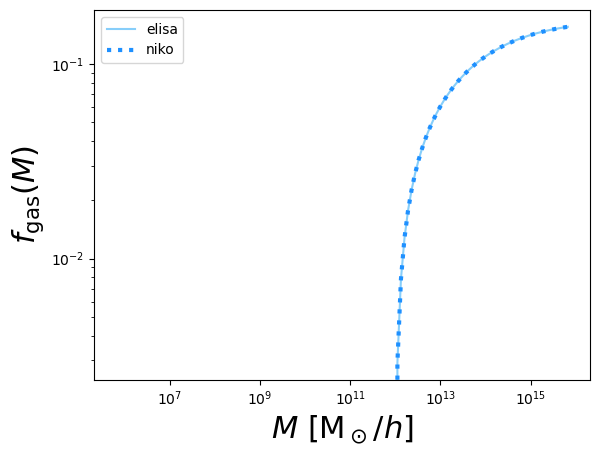

In [11]:
%%time
def f_gas(m):
    fgas = []
    for i in m:
        if i<m_0g:
            fgas.append(0.)
        else:
            fgas.append((cosmo['Omega_b']/cosmo['Omega_m'])*erf(np.log10(i/m_0g)/sigmag))
    return fgas

plt.figure()
plt.loglog(m_arr*cosmo['h'], f_gas(m_arr), c="lightskyblue", label="elisa")
plt.loglog(m_arr*cosmo['h'], mass_frac_dict["gas"], c='dodgerblue', ls=":", label="niko", lw=3)
plt.xlabel(r'$M$ $[$M$_\odot/h]$',fontsize=22)
plt.ylabel(r'$f_{\rm gas}(M)$',fontsize=22)
plt.legend()

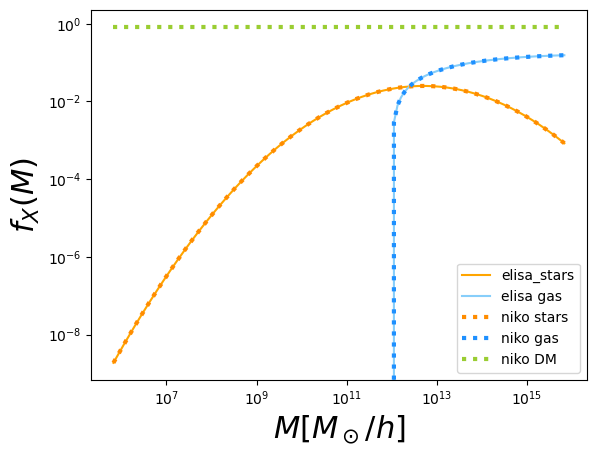

In [12]:
plt.figure()
plt.loglog(m_arr*cosmo['h'], f_star(m_arr), c='orange', label="elisa_stars")
plt.loglog(m_arr*cosmo['h'], f_gas(m_arr), c='lightskyblue', label="elisa gas")
plt.loglog(m_arr*cosmo['h'], mass_frac_dict["stars"], c='darkorange', ls=":", label="niko stars", lw=3)
plt.loglog(m_arr*cosmo['h'], mass_frac_dict["gas"], c='dodgerblue', ls=":", label="niko gas", lw=3)
plt.loglog(m_arr*cosmo['h'], mass_frac_dict["dark_matter"], c='yellowgreen', ls=":", label="niko DM", lw=3)
plt.xlabel(r'$M [M_\odot/h]$',fontsize=22)
plt.ylabel(r'$f_X(M)$',fontsize=22)
plt.legend()
plt.show()

We now define a class that describes the profiles for the bound gas. Note we use a slightly different gas profile to Fedeli (2014):

$\rho_g(r)=\frac{\rho_{g,0}}{(1+u)^\beta(1+v^2)^{(7-\beta)/2}}$, with $u:=r/r_{co}$ and $v:=r/r_{ej}$.

In [13]:
%%time
#THIS IS ELISA ORIGINAL
class HaloProfileGas(ccl.halos.HaloProfile):
    def __init__(self,mass_def):
        super(HaloProfileGas, self).__init__(mass_def=mass_def)
        
    #scale radius
    def _rs(self, cosmo, M, a):
        return self.mass_def.get_radius(cosmo, M, a) / a 

    #def _rint(self, M, Rd, r):
    def _rint_old(self, M, Rd, r):
        r_co = 0.1*Rd
        r_ej = 4.5*Rd #just placeholder value
        return r**2/((1+r/r_co)**beta*(1+(r/r_ej)**2)**((7-beta)/2))

    def _rint(self, Rd, r):
        r_co = 0.1 * Rd  # Core radius
        r_ej = 4.5 * Rd  # Envelope radius, placeholder value
        r_int = r**2 / ((1 + r / r_co)**beta * (1 + (r / r_ej)**2)**((7 - beta) / 2))
        return r_int
    
    def _norm(self, M, Rd):
        nn = f_gas(M) * M / (4 * np.pi * np.array([
            integrate.romberg(partial(self._rint, rd),
                              1E-3, 50, tol=0, rtol=1E-3, divmax=5000)
            for rd in Rd
        ]))
        
        return nn

    def _real(self, cosmo, r, M, a):
        # Generate 2D array by default
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # Compute profile
        r_delta = self._rs(cosmo, M_use, a)
        r_co = 0.1*r_delta
        r_ej = 4.5*r_delta

        prof = 1/((1+r_use[None,:]/r_co[:,None])**beta*(1+(r_use[None,:]/r_ej[:,None])**2)**((7-beta)/2))
        norm = self._norm(M_use,r_delta)
        prof = prof[:,:]*norm[:,None]

        # Make sure the output has the right shape
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

pg = HaloProfileGas(mass_def=hmd_200m)
pg.update_precision_fftlog(padding_hi_fftlog=1E3,padding_lo_fftlog=1E-3,
                           n_per_decade=1000,plaw_fourier=-2.)

CPU times: user 226 µs, sys: 1 µs, total: 227 µs
Wall time: 232 µs


## Interpolation of profiles

It takes a while to evaluate the profiles. For this reason, we are going to interpolate them so we can use them later.

In [14]:
%%time
# THIS IS NIKO STUFF

# Either compute each profile individually
# dm_interpolated = bhm.interpolated_profiles("dark_matter")
# gas_interpolated = bhm.interpolated_profiles("gas")
# stellar_interpolated = bhm.interpolated_profiles("stars")

# Or compute all at once and access them as dict keys
profiles = bhm.profiles_dict()


All profiles (dark_matter, gas, stars) have been interpolated and stored.
CPU times: user 23 s, sys: 2.77 s, total: 25.7 s
Wall time: 5.21 s


In [15]:
%%time
#Interpolate the profiles for speed

## Check transpose needed?

nk=1500
nm=500
k_interp_vec = np.logspace(-4,2,num=nk)
mass_interp_vec = np.logspace(np.log10(mmin_DM),np.log10(mmax_DM),num=nm)

##### DM #####
yDM=np.zeros((len(mass_interp_vec),len(k_interp_vec)))
M2D = np.zeros((len(mass_interp_vec),len(k_interp_vec)))
for i in range(0,len(k_interp_vec)):
    M2D[:,i]=mass_interp_vec

for j in range(0,len(mass_interp_vec)):
    yDM[j,:]=pM.fourier(cosmo, k_interp_vec, mass_interp_vec[j], a)/mass_interp_vec[j]
#fDM = interpolate.interp2d(mass_interp_vec,k_interp_vec,np.transpose(yDM))
fDM = interpolate.RegularGridInterpolator((mass_interp_vec,k_interp_vec), yDM, method='cubic')
print("DM profiles interpolated...\n")

##### Gas #####
mass_interp_vec = np.logspace(np.log10(mmin_gas),np.log10(mmax_gas),num=nm)

yg=np.zeros((len(mass_interp_vec),len(k_interp_vec)))
M2D = np.zeros((len(mass_interp_vec),len(k_interp_vec)))
for i in range(0,len(k_interp_vec)):
    M2D[:,i]=mass_interp_vec

for j in range(0,len(mass_interp_vec)):
    yg[j,:]=pg.fourier(cosmo, k_interp_vec,mass_interp_vec[j], a)/mass_interp_vec[j]
    
#f = interpolate.interp2d(mass_interp_vec,k_interp_vec,np.transpose(yg))
fgas = interpolate.RegularGridInterpolator((mass_interp_vec,k_interp_vec), yg, method='cubic')
print("Gas profiles interpolated...\n")

##### Stars #####
mass_interp_vec = np.logspace(np.log10(mmin_stars),np.log10(mmax_stars),num=nm)

M2D = np.zeros((len(mass_interp_vec),len(k_interp_vec)))
for i in range(0,len(k_interp_vec)):
    M2D[:,i]=mass_interp_vec

ys=ps.fourier(cosmo, k_interp_vec,mass_interp_vec, a)/M2D
#fs = interpolate.interp2d(mass_interp_vec,k_interp_vec,np.transpose(ys))
fs = interpolate.RegularGridInterpolator((mass_interp_vec,k_interp_vec), ys,method='cubic')

print("Star profiles interpolated...\n")


DM profiles interpolated...



<timed exec>:24: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.


Gas profiles interpolated...

Star profiles interpolated...

CPU times: user 37 s, sys: 4.19 s, total: 41.2 s
Wall time: 6.43 s
Compiler : 178 ms


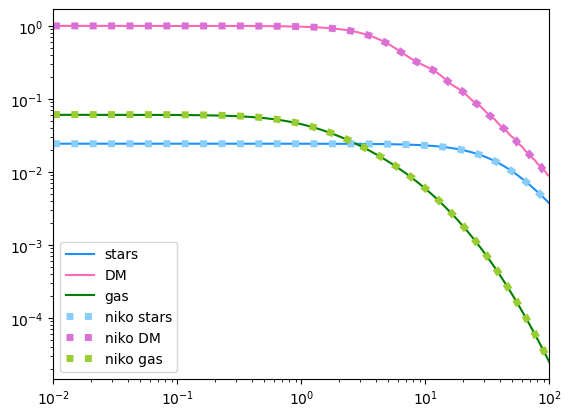

In [16]:
#This is to eyeball the profiles to make sure they make sense
#Compare to Fedeli paper 
mplot=1e13/cosmo['h']
plt.plot(k_interp_vec,fs((mplot,k_interp_vec)),'dodgerblue',label='stars')
plt.plot(k_interp_vec,fDM((mplot,k_interp_vec)),'hotpink',label='DM')
plt.plot(k_interp_vec,fgas((mplot,k_interp_vec)),'green',label='gas')

plt.plot(k_interp_vec, profiles["stars"]((mplot, k_interp_vec)), c="lightskyblue", ls=":", lw=5,  label="niko stars")
plt.plot(k_interp_vec, profiles["dark_matter"]((mplot, k_interp_vec)), c="orchid", ls=":", lw=5, label="niko DM")
plt.plot(k_interp_vec, profiles["gas"]((mplot, k_interp_vec)), c="yellowgreen", ls=":", lw=5,  label="niko gas")

plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin=1e-2,xmax=1e2)
plt.legend()
#plt.show()

## Calculation of power spectra

We define some generic integrals that are needed for the one halo and two halo power spectra of the different components of the model:

$I_{2p}=\int_0^\infty dm n(m) m^2y_1(k)y_2(k)$

$I_{bp}=\int_0^\infty dm n(m) b(m) my(k)$

In [17]:
%%time
# Halo Mass Calculator (for DM)
hmc = ccl.halos.HMCalculator(mass_function=hmf_200m, halo_bias=hbf, mass_def=hmd_200m)

# Non-linear matter power spectrum, for comparison
pk_nl = ccl.nonlin_matter_power(cosmo, k_arr, a)

#Generic integrals we need
#(of the form 5.x in Fedeli (2014))
def integrandGEN2p(m,k,prof1,prof2):
    dndlog10m = hmf_200m(cosmo, m, a)  # !!!!!a is not in the args here but should be
    dndm=dndlog10m/(m*np.log(10.))
    y1=prof1((m,k))
    y2 =prof2((m,k))
    return dndm*m**2*y1*y2  
def integratedGEN2p(mmin,mmax,k,p1,p2):
    return integrate.quad(integrandGEN2p, mmin, mmax, args=(k,p1,p2),epsabs=0,epsrel=1E-2,limit=1000)[0]
def integrandGENbp(m,k,prof1):
    bm = hbf(cosmo,m,a)
    dndlog10m = hmf_200m(cosmo, m, a)
    dndm=dndlog10m/(m*np.log(10.))
    y=prof1((m,k))
    return dndm*m*bm*y
def integratedGENbp(mmin,mmax,k,p1):
    return integrate.quad(integrandGENbp, mmin, mmax, args=(k,p1),epsabs=0,epsrel=1E-2,limit=1000)[0]

CPU times: user 175 ms, sys: 159 ms, total: 333 ms
Wall time: 334 ms


We start with the dark matter:

In [ ]:
%%time
#Dark matter auto-spectra

def PDM2h(k):
    return ccl.linear_matter_power(cosmo, k, a)/rho_DM**2*integratedGENbp(mmin_DM,mmax_DM,k,fDM)**2

def PDM1h(k):
    return 1/rho_DM**2*integratedGEN2p(mmin_DM, mmax_DM, k, fDM, fDM)

PDM1h_arr=np.zeros(len(k_arr))
PDM2h_arr=np.zeros(len(k_arr))
for i in range(0, len(k_arr)):
    PDM1h_arr[i]=PDM1h(k_arr[i])
    PDM2h_arr[i]=PDM2h(k_arr[i])

Then the gas:

In [ ]:
%%time
#Gas auto-spectra

def PG2h(k):
    return ccl.linear_matter_power(cosmo, k, a)/(Fg*rho_g)**2*integratedGENbp(mmin_gas,mmax_gas,k,fgas)**2

def PG1h(k):
    return 1/(Fg*rho_g)**2*integratedGEN2p(mmin_gas,mmax_gas,k,fgas,fgas)

def PGd(k):
    return bd**2*ccl.linear_matter_power(cosmo, k, a)

def PGdh(k):
    return bd*ccl.linear_matter_power(cosmo, k, a)/(Fg*rho_g)*integratedGENbp(mmin_gas,mmax_gas,k,fgas)

PG2h_arr=np.zeros(len(k_arr))
PG1h_arr=np.zeros(len(k_arr))
PGd_arr=np.zeros(len(k_arr))
PGdh_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PG2h_arr[i]=PG2h(k_arr[i])
    PGd_arr[i]=PGd(k_arr[i])
    PG1h_arr[i]=PG1h(k_arr[i])
    PGdh_arr[i]=PGdh(k_arr[i])

PG = Fg**2*(PG2h_arr + PG1h_arr) + (1-Fg)**2*PGd_arr + 2*Fg*(1-Fg)*PGdh_arr

We will now compute all spectra that involve a stellar contribution:

In [ ]:
%%time
#Stars auto spectrum
def PS2h(k):
    return ccl.linear_matter_power(cosmo, k, a)/rho_star**2*integratedGENbp(mmin_stars,mmax_stars,k,fs)**2

def PS1h(k):
    return 1/rho_star**2*integratedGEN2p(mmin_stars,mmax_stars,k,fs,fs)

PS2h_arr=np.zeros(len(k_arr))
PS1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PS2h_arr[i]=PS2h(k_arr[i])
    PS1h_arr[i]=PS1h(k_arr[i])

In [ ]:
%%time
#DM x gas
def return_integrandDM(k):
    return integratedGENbp(mmin_DM,mmax_DM,k,fDM)
def PDMgdh(k):
    return (bd*ccl.linear_matter_power(cosmo, k, a)/rho_DM)
def PDMg1h(k):
    #problem here
    return 1/(rho_DM*Fg*rho_g)*integratedGEN2p(mmin_gas,mmax_gas,k,fgas,fDM)
def PDMg2h(k):
    return ccl.linear_matter_power(cosmo, k, a)/(rho_DM*Fg*rho_g)*integratedGENbp(mmin_gas,mmax_gas,k,fgas)

useful_integrand_arr=np.zeros(len(k_arr))
PDMgdh_arr=np.zeros(len(k_arr))
PDMg2h_arr=np.zeros(len(k_arr))
PDMg1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    useful_integrand_arr[i]=return_integrandDM(k_arr[i])
    PDMgdh_arr[i]=PDMgdh(k_arr[i])*useful_integrand_arr[i]
    PDMg1h_arr[i]=PDMg1h(k_arr[i])
    PDMg2h_arr[i]=PDMg2h(k_arr[i])*useful_integrand_arr[i]

PDMg = (1-Fg)*PDMgdh_arr + Fg*(PDMg1h_arr+PDMg2h_arr)

In [ ]:
%%time
#DM x stars
def PDMs1h(k):
    return 1/(rho_DM*rho_star)*integratedGEN2p(mmin_stars,mmax_stars,k,fDM,fs)

def PDMs2h(k):
    ii=integratedGENbp(mmin_stars,mmax_stars,k,fs)*integratedGENbp(mmin_DM,mmax_DM,k,fDM)
    return ccl.linear_matter_power(cosmo, k, a)/(rho_DM*rho_star)*ii

#Eval and add DM x stars
PDMs1h_arr=np.zeros(len(k_arr))
PDMs2h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    PDMs1h_arr[i]=PDMs1h(k_arr[i])
    PDMs2h_arr[i]=PDMs2h(k_arr[i])
PDMs = PDMs1h_arr+PDMs2h_arr

In [ ]:
%%time
#Stars x gas
def Psgh(k):
    return bd*ccl.linear_matter_power(cosmo, k, a)/rho_star*integratedGENbp(mmin_stars,mmax_stars,k,fs)

def Psg1h(k):
    # ask elisa about this
    return 1/(rho_star*Fg*rho_g)*integratedGEN2p(mmin_gas,mmax_stars,k,fgas,fs)  # min and max dont match!


def Psg2h(k):
    ii=integratedGENbp(mmin_stars,mmax_stars,k,fs)*integratedGENbp(mmin_gas,mmax_gas,k,fgas)
    return ccl.linear_matter_power(cosmo, k, a)/(rho_star*Fg*rho_g)*ii

#Eval and add star x gas
Psgh_arr=np.zeros(len(k_arr))
Psg2h_arr=np.zeros(len(k_arr))
Psg1h_arr=np.zeros(len(k_arr))
for i in range(0,len(k_arr)):
    Psgh_arr[i]=Psgh(k_arr[i])
    Psg1h_arr[i]=Psg1h(k_arr[i])
    Psg2h_arr[i]=Psg2h(k_arr[i])
Psg = (1-Fg)*Psgh_arr + Fg*(Psg1h_arr+Psg2h_arr)

Now plot them all and add them to form the total. We will plot them relative to the standard nonlinear matter power spectrum from CCL, which does not account for baryons.

In [ ]:
%%time
#Auto-spectra
Pauto = (rho_DM/rho_m)**2*(PDM2h_arr+PDM1h_arr)+(rho_g/rho_m)**2*PG+(rho_star/rho_m)**2*(PS1h_arr+PS2h_arr)
#Cross-spectra
Pcross = (2*rho_DM*rho_star*PDMs +2*rho_g*rho_star*Psg+2*rho_DM*rho_g*PDMg)/(rho_m**2)
#Add all
Ptotal = Pauto + Pcross

#Relative power spectra
plt.figure(figsize=(7,8))
#All auto correl
plt.plot(k_arr/cosmo['h'], (rho_DM/rho_m)**2*(PDM2h_arr+PDM1h_arr)/pk_nl, 'k-', label='$P_{DM}(k)$')
plt.plot(k_arr/cosmo['h'], (rho_g/rho_m)**2*PG/pk_nl, 'r-', label='$P_{G}(k)$')
plt.plot(k_arr/cosmo['h'], (rho_star/rho_m)**2*(PS2h_arr+PS1h_arr)/pk_nl, 'b-', label='$P_{S}(k)$')
#All cross correl
plt.plot(k_arr/cosmo['h'], 2*rho_DM*rho_g/(rho_m**2)*PDMg/pk_nl, 'g-', label='$P_{DM,G}(k)$')
plt.plot(k_arr/cosmo['h'], 2*rho_g*rho_star/(rho_m**2)*Psg/pk_nl, 'm-', label='$P_{G,S}(k)$')
plt.plot(k_arr/cosmo['h'], 2*rho_DM*rho_star/(rho_m**2)*PDMs/pk_nl, 'c-', label='$P_{DM,S}(k)$')
#And the total with respect to CAMBs nonlinear power
plt.plot(k_arr/cosmo['h'], Ptotal/pk_nl, 'k--', label='$P_{total}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=12.5)
plt.ylabel(r'$P(k)/P_{nl}(k)$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm h/Mpc}]$', fontsize=15)
plt.show()


# Pk validation

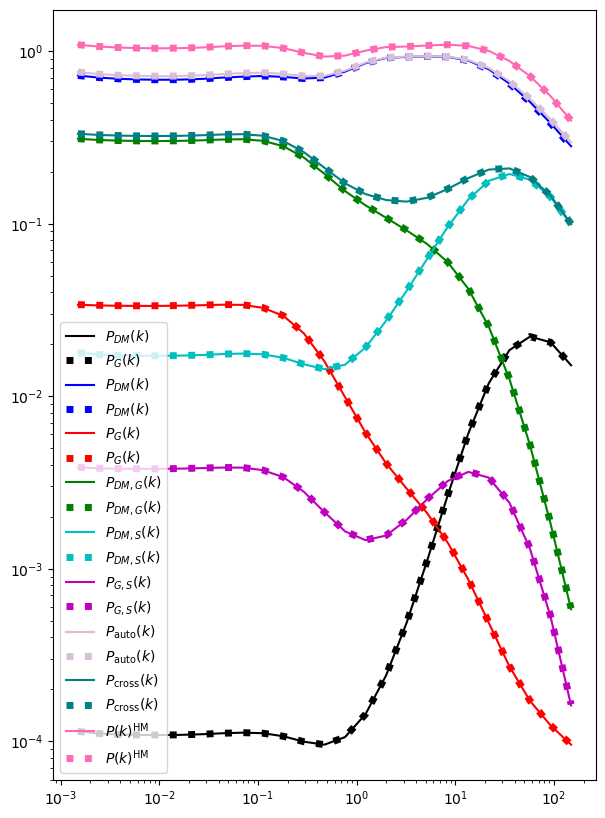

In [18]:
# In order not to compute all this stuff as it takes a while, I saved the results to dicts.
# Now we load those dicts: data from Elisa (from this notebook) and data from Niko bhm code:
pk_elisa = np.load("data/baryons_hm_pk_data_elisa.npy", allow_pickle=True).item()
pk_niko = np.load("data/baryons_halo_model_pk.npy", allow_pickle=True).item()
# I will also load the terms that make up the power spectra.
terms_dict = np.load("data/baryons_halo_model_terms.npy", allow_pickle=True).item()
prefac_dict = bhm.prefactor_dict()  # these are the prefactors to multiply the power spectra by
pk_nlin = ccl.nonlin_matter_power(cosmo, k_arr, a)  # nonlinear pk from CCL

k_xaxis = k_arr/cosmo['h']

plt.figure(figsize=(7, 10))
# stars
plt.loglog(k_xaxis, (rho_star/rho_m)**2*pk_elisa["stars"]/pk_nlin, 'k-', label='$P_{DM}(k)$')
plt.loglog(k_xaxis, prefac_dict["stars"]*pk_niko["stars"]/pk_nlin, 'k:', label='$P_{G}(k)$', lw=5)
# dark matter
plt.loglog(k_xaxis, (rho_DM/rho_m)**2*pk_elisa["dm"]/pk_nlin, 'b-', label='$P_{DM}(k)$')
plt.loglog(k_xaxis, prefac_dict["dark_matter"]*pk_niko["dark_matter"]/pk_nlin, 'b:', label='$P_{DM}(k)$', lw=5)
# gas
plt.loglog(k_xaxis, (rho_g/rho_m)**2*pk_elisa["gas"]/pk_nlin, 'r-', label='$P_{G}(k)$')
plt.loglog(k_xaxis, prefac_dict["gas"]*pk_niko["gas"]/pk_nlin, 'r:', label='$P_{G}(k)$', lw=5)
# DM x gas
plt.loglog(k_xaxis, 2*rho_DM*rho_g/(rho_m**2)*pk_elisa["dmgas"]/pk_nlin, 'g-', label='$P_{DM,G}(k)$')
plt.loglog(k_xaxis, prefac_dict["dark_matter_gas"]*pk_niko["dark_matter_gas"]/pk_nlin, 'g:', label='$P_{DM,G}(k)$', lw=5)
# DM x stars
plt.loglog(k_xaxis, 2*rho_DM*rho_star/(rho_m**2)*pk_elisa["dmstars"]/pk_nlin, 'c-', label='$P_{DM,S}(k)$')
plt.loglog(k_xaxis, prefac_dict["dark_matter_stars"]*pk_niko["dark_matter_stars"]/pk_nlin, 'c:', label='$P_{DM,S}(k)$', lw=5)
# gas x stars
plt.loglog(k_xaxis, 2*rho_g*rho_star/(rho_m**2)*pk_elisa["gasstars"]/pk_nlin, 'm-', label='$P_{G,S}(k)$')   
plt.loglog(k_xaxis, prefac_dict["stars_gas"]*pk_niko["stars_gas"]/pk_nlin, 'm:', label='$P_{G,S}(k)$', lw=5)

# auto
plt.loglog(k_xaxis, pk_elisa["auto_all"]/pk_nlin, c="thistle", label='$P_{\mathrm{auto}}(k)$')
plt.loglog(k_xaxis, pk_niko["auto"]/pk_nlin, c="thistle", ls=":", label='$P_{\mathrm{auto}}(k)$', lw=5)
# cross
plt.loglog(k_xaxis, pk_elisa["cross_all"]/pk_nlin, c="teal", label='$P_{\mathrm{cross}}(k)$')
plt.loglog(k_xaxis, pk_niko["cross"]/pk_nlin, c="teal", ls=":", label='$P_{\mathrm{cross}}(k)$', lw=5)
# total
plt.loglog(k_xaxis, pk_elisa["total"]/pk_nlin, c="hotpink", label='$P(k)^\mathrm{HM}$')
plt.loglog(k_xaxis, pk_niko["total"]/pk_nlin, c="hotpink", ls=":", label='$P(k)^\mathrm{HM}$', lw=5)

plt.legend()


In [ ]:
# pk_elisa.keys()

# pk_niko.keys()

In [ ]:

data_dict = {
    # Auto spectra
    # dark matter
    "dm_1h": PDM1h_arr,
    "dm_2h": PDM2h_arr,
    "dm": PDM2h_arr + PDM1h_arr,
    # gas
    "gas_1h": PG1h_arr,
    "gas_2h": PG2h_arr,
    "gas_d": PGd_arr,
    "gas_dh": PGdh_arr,
    "gas": PG,
    # stars
    "stars_1h": PS1h_arr,
    "stars_2h": PS2h_arr,
    "stars": PS2h_arr + PS1h_arr,
    # Cross spectra
    # dark matter - gas
    "dmgas_1h": PDMg1h_arr,
    "dmgas_2h": PDMg2h_arr,
    "dmgas_dh": PDMgdh_arr,
    "dmgas": PDMg,
    # gas - stars
    "gasstars_1h": Psg1h_arr,
    "gasstars_2h": Psg2h_arr,
    "gasstars_dh": Psgh_arr,
    "gasstars": Psg,
    # dark matter - stars
    "dmstars_1h": PDMs1h_arr,
    "dmstars_2h": PDMs2h_arr,
    "dmstars": PDMs,
    # All
    'auto_all': Pauto,
    'cross_all': Pcross,
    "total": Ptotal
}


# Then we save the data dictionary to a npy file
labels_dict = {
    "dm": "$P_{DM}(k)$",
    "g": "$P_{G}(k)$",
    "s": "$P_{S}(k)$",
    "dm_g": "$P_{DM, G}(k)$",
    "g_s": "$P_{G, S}(k)$",
    "dm_s": "$P_{DM, S}(k)$",
    "total": "$P(k)^\mathrm{HM}$",
    "auto_all": "$P_{\mathrm{auto}}(k)$",
    "cross_all": "$P_{\mathrm{cross}}(k)$"
}

# Then we save the data dictionary to a npy file
#np.save("data/baryons_hm_pk_data_elisa.npy", plot_data_dict)
#np.save("data/baryons_hm_pk_labels_elisa.npy", labels_dict)